## Spam / Ham Detection 
Spam/Ham Detection is a classic binary classification problem, which people in Gmail or Outlook must have been working with. Although they must be having complex method with a lot more features than only the mail body. Anyway, the gist remains the same, that is, binary classification of text. 

Alhtough spams and hams are popular in mails only, we are here classifying the text messages. Let's get started then.

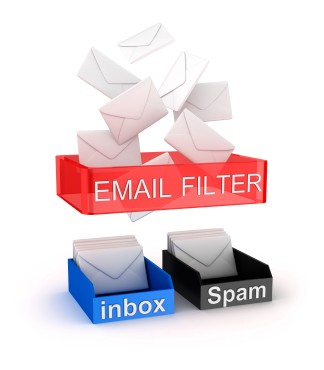

## Machine Learning problem formulation

**Problem Statement: ** Make a binary classification model, which will classify given a message, whether that message is a spam or a ham (genuine).

**Model to be used: ** We will use Recurrent Neural Network (RNN) with Long-Short Term Memory (LSTM) model to classify the messages. I will explain what an RNN is, in later part of the kernel.

**Loss Function: ** We will use Categorical CrossEntropy as a loss, to train our RNN model.

**Performance metric :** Which metric to use to evaluate the model? (Is our class label imbalanced ?)

In [ ]:
# Importing the libraries

# For dealing with warnings
import warnings
warnings.filterwarnings("ignore")

# Data preprocessing and Vectorization
import numpy as np 
import pandas as pd

# Data Visualizations 
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px

# Making the NN model
from keras.utils import to_categorical
from keras.models import Sequential 
from keras.layers import Dense, LSTM, Dropout
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

## 1. Overview of Data

In [ ]:
# Loading the data 
data = pd.read_csv("/kaggle/input/spam-text-message-classification/SPAM text message 20170820 - Data.csv")
data.head()

We have two features in the dataset, one is the message body and other is the category whether it's a spam or a ham message. 

In [ ]:
print("Total number of messages: ", data.shape[0])

In [ ]:
# General information about the data
data.info()

In [ ]:
# Is there any null or missing value?
data.isna().sum()

<h3>Conclusions: </h3> 
1. Total number of data points are 5572.
2. There are no null values in both the features of data.

## 2. Exploratory Data Analysis

In [ ]:
# How many data points in each class ?
data["Category"].value_counts()

In [ ]:
sns.set_style("whitegrid")
sns.countplot(data["Category"])

In [ ]:
# Let's see the distribution of length of messages in each category.
# Make a new column saying msg_length
data ["msg_len"] = data["Message"].apply(len)

In [ ]:
fig = px.violin(data_frame=data, y="msg_len", points="all", color="Category", 
                width=800, height=600)
fig.show()

Length of messages differ drastically, across two categories.

Median length of spams and hams are 52 and 149 respectively. That is something we should look upon.

In [ ]:
sns.set(style="whitegrid")
sns.violinplot(x="Category", y="msg_len", data=data)

### 2.1. Outlier Detection in terms of length for both the classes

In [ ]:
spam_data = data[data["Category"] == "spam"]
ham_data = data[data["Category"] == "ham"]

In [ ]:
def num_of_outliers(df, col):
    q1 = np.percentile(df[col].values, q=25)
    q3 = np.percentile(df[col].values, q=75)
    iqr = q3 - q1
    upper_limit = q3 + (iqr * 1.5)
    lower_limit = q1 - (iqr * 1.5)
    
    print("Q1: ", q1)
    print("Q3: ", q3)
    print("IQR: ", iqr)
    print("Lower fence: ", lower_limit)
    print("Upper fence: ", upper_limit)
    print()
    num_outliers = df[(df[col] < lower_limit) | (df[col] > upper_limit)].shape[0]
    
    return num_outliers

In [ ]:
ham_num_out = num_of_outliers(df=ham_data, col="msg_len")

print("Number of outliers in ham data: {}".format(ham_num_out))

In [ ]:
spam_num_out = num_of_outliers(df=spam_data, col="msg_len")

print("Number of outliers in spam data: {}".format(spam_num_out))

We will remove the outliers from spam messages as they seem to be very long length for few cases. We will not remove the outliers from spam messages though. They seem to be of comparable length if we see overall data. 

Let' see few of the messages of both the categories.

In [ ]:
# Let's look at the few spams
spam_messages = spam_data["Message"]
random_indices = np.random.randint(low=0, high=spam_messages.shape[0], size=5)
for idx in random_indices:
    print(spam_messages.iloc[idx])
    print()
    print("#"*70)
    print()

In [ ]:
# Let's look at some of the ham messages
ham_messages = ham_data["Message"]
random_indices = np.random.randint(low=0, high=ham_messages.shape[0], size=5)
for idx in random_indices:
    print(ham_messages.iloc[idx])
    print()
    print("#"*70)
    print()

Overall coversations are less formal, be it ham or spam message. People have used many short words or message slangs.

Spam messages seem to have more numbers, links, or currency signs with large numbers.

Let's see the wordcloud for both the categories.

In [ ]:
def plot_wordclouds(message_column):
    msg_string = ""
    for msg in message_column.values:
        msg_string += msg.lower() + " "

    msg_string = msg_string.strip()    

    from wordcloud import WordCloud, STOPWORDS
    plt.figure(figsize=(20, 10))
    wordcloud = WordCloud(width=1200, height=800, background_color="black", stopwords=STOPWORDS, 
                          min_font_size=10, include_numbers=True).generate(msg_string)
    plt.axis("off")
    plt.grid(None)
    plt.imshow(wordcloud)

In [ ]:
plot_wordclouds(spam_messages)

In [ ]:
plot_wordclouds(ham_messages)

If we have a good peek on the data we will find that many spam messages have numbers (mobile number or winning lottery amount etc.) as well as URLs. We will make a features out of them.

**number_count:** count of all the numbers with5 or greater than 5 digits.

**url_count:** number of URL count in the message.

Let's see number_count first for both of the data.

In [ ]:
import re
def get_numbers(s):
    return len(re.findall("\d{5,}", s))

In [ ]:
spam_data["number_count"] = spam_data["Message"].apply(get_numbers)
spam_data["number_count"].value_counts()

In [ ]:
ham_data["number_count"] = ham_data["Message"].apply(get_numbers)
ham_data["number_count"].value_counts()

In [ ]:
def get_num_urls(s):
    return len(re.findall("(http|https|www)\:\/\/[a-zA-Z0-9\-\.]+\.[a-zA-Z]{2,3}(\/\S*)?", s))

In [ ]:
spam_data["url_count"] = spam_data["Message"].apply(get_num_urls)
spam_data["url_count"].value_counts()

In [ ]:
ham_data["url_count"] = ham_data["Message"].apply(get_num_urls)
ham_data["url_count"].value_counts()

### Data preprocessing, Feature Engineering

In [ ]:
# Adding number count as feature
data["number_count"] = data["Message"].apply(get_numbers)

In [ ]:
# Adding url count as feature
data["url_count"] = data["Message"].apply(get_num_urls)

In [ ]:
# Removing the ourliers
data = data[data["msg_len"] < 183]

In [ ]:
# Data preprocessing 

import re
import nltk
from nltk import WordNetLemmatizer
from nltk.corpus import stopwords

stop_words = stopwords.words("english")

def clean_message(msg):
    # lowercase
    msg = msg.lower()
    # removing special characters
    msg = re.sub("[^a-zA-Z]", " ", msg)
    # word tokenize 
    msg = nltk.word_tokenize(msg)
    # Lemmatization 
    lemma = WordNetLemmatizer()
    msg = [lemma.lemmatize(word) for word in msg if word not in stop_words and len(word) > 1]
    
    # Joining the words back 
    msg = " ".join(msg)
    
    return msg

In [ ]:
data["cleaned_msg"] = data["Message"].apply(clean_message)

In [ ]:
data["is_spam"] = data["Category"].apply(lambda x: 1 if x == "spam" else 0)

In [ ]:
data.drop(labels=["Message", "Category"], inplace=True, axis=1)

In [ ]:
data.head()

In [ ]:
# Let's go for tf-idf vectorizer

In [ ]:
# I am taking very less features so that, it trains faster.
# You can take something like 200 to 300 features. That should be good.
tfidf = TfidfVectorizer(max_df=.8, max_features=50)
tfidf_mat = tfidf.fit_transform(data.iloc[:,3].values)
y = data["is_spam"].values

X = np.hstack((tfidf_mat.toarray(), data.iloc[:, 0:3].values))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, stratify=y)

In [ ]:
X_train_nn = X_train.reshape(-1, X_train.shape[1], 1)
X_test_nn = X_test.reshape(-1, X_test.shape[1], 1)
y_train_nn = to_categorical(y_train)
y_test_nn = to_categorical(y_test)


model = Sequential()

# Units - outputs dimension 
model.add(LSTM(units=50, activation="relu", return_sequences=True))
model.add(Dropout(rate=0.2))

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

# Adding a third LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

# Adding a fourth LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50))
model.add(Dropout(0.2))

model.add(Dense(units=2))

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

history = model.fit(X_train_nn, y_train_nn, epochs=10, batch_size=32, verbose=1, validation_data=(X_test_nn, y_test_nn))

In [ ]:
history.history

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()